# <center>Organizaci&oacute;n de Datos</center>
#### <center>C&aacute;tedra Ing. Rodriguez, Juan Manuel </center>

## <center>Trabajo Práctico 1</center>
## <center>Checkpoint 3 : Ensambles de modelos</center> 

# Consigna

  1. Construir un **clasificador KNN** optimizar sus hiperparámetros mediante k-fold
Cross Validation
  2. Construir un **clasificador SVM** variando el kernel y los parámetros.
  3. Construir un **clasificador RF** y optimizar sus hiperparámetros mediante **k-fold Cross Validation**
  4. Construir un **clasificador XGBoost** y optimizar sus hiperparámetros.
  5. Construir un **ensamble híbrido** tipo **Voting** y otro tipo **Stacking**.
  6. Evaluar la performance de todos los modelos en entrenamiento y validación explicar todas las métricas y mostrar la matriz de confusión.
  7. Generar predicciones con el set de test y realizar los submits correspondientes en la competencia de Kaggle.

# Inicializacion de entorno

## Librerías

In [2]:
!pip install dtreeviz
!pip install geopandas


Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 91.5/91.5 kB 8.6 MB/s eta 0:00:00
Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.1/1.1 MB 57.0 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 16.0/16.0 MB 101.6 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 7.7/7.7 MB 132.1 MB/s eta 0:00:00


In [3]:
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
import numpy as np
import sklearn as sk
from collections import defaultdict
from sklearn.model_selection import cross_val_score, RepeatedStratifiedKFold
import plotly.graph_objects as go
from sklearn import preprocessing
from sklearn.preprocessing import (
    KBinsDiscretizer,
    LabelEncoder,
    MinMaxScaler,
    Normalizer,
    OneHotEncoder,
    OrdinalEncoder,
    PowerTransformer,
    RobustScaler,
    StandardScaler,
)
from sklearn.model_selection import (
    StratifiedKFold,
    KFold,
    RandomizedSearchCV,
    GridSearchCV,
    cross_val_score,
    cross_validate,
    train_test_split,
)
from sklearn import tree



from sklearn.metrics import confusion_matrix, classification_report
from sklearn.metrics import make_scorer
from sklearn.metrics import precision_recall_curve, roc_curve, recall_score, accuracy_score,f1_score

from sklearn.linear_model import (LinearRegression, LogisticRegressionCV)
from sklearn.ensemble import (IsolationForest, RandomForestClassifier, GradientBoostingRegressor)
from sklearn.tree import (DecisionTreeClassifier, export_graphviz)
from sklearn import metrics
from sklearn.cluster import KMeans
from sklearn.neighbors import KNeighborsClassifier
from sklearn.neighbors import KNeighborsRegressor
from sklearn.svm import SVC

import dtreeviz.trees as dtreeviz
from tqdm import tqdm
from joblib import dump, load
import xgboost as xgb

from datetime import datetime

#Visualización
import dtreeviz.trees as dtreeviz

#modelos y métricas
from sklearn.model_selection import train_test_split
from sklearn.metrics import precision_score, recall_score, accuracy_score,f1_score#, precision_recall_curve, roc_curve,
from sklearn.metrics import confusion_matrix, classification_report

#configuración warnings
import warnings
warnings.simplefilter(action='ignore', category=FutureWarning)
warnings.simplefilter(action='ignore', category=UserWarning)


## Funciones

In [4]:
def metricas_modelo(test, pred):
  #Calculo las métricas en el conjunto de evaluación
  accuracy=accuracy_score(test, pred)
  recall=recall_score(test, pred)
  f1=f1_score(test, pred)
  precision=precision_score(test, pred)

  metrics=[[str(round(accuracy,5)), str(round(recall,5)), str(round(precision,5)), str(round(f1,5))]]
  labels=['Accuracy', 'Recall', 'Precision', 'F1']
  
  matriz=confusion_matrix(test, pred)
  
  plt.table(cellText=metrics,
            colLabels=labels,
            bbox=(1.5, .1, 0.75, 0.75))
  
  #Grafico la matriz de confusión
  sns.heatmap(matriz,cmap='Blues',annot=True,fmt='g')
  plt.xlabel('Predicted')
  plt.ylabel('True')



In [5]:
def metricas(y_pred,y_test):

    print(classification_report(y_test,y_pred))
    
    cm = confusion_matrix(y_test,y_pred)
    sns.heatmap(cm, cmap='Blues',annot=True,fmt='g')
    plt.xlabel('Predicted')
    plt.ylabel('True')

In [6]:
#Funcion para plotear a performance
def plot_results(model_scores, name):
    
    model_names = list(model_scores.keys())
    results = [model_scores[model] for model in model_names]
    fig = go.Figure()
    for model, result in zip(model_names, results):
        fig.add_trace(go.Box(
            y=result,
            name=model,
            boxpoints='all',
            jitter=0.5,
            whiskerwidth=0.2,
            marker_size=2,
            line_width=1)
        )
    
    fig.update_layout(
    title='Performance of Different Models Using 5-Fold Cross-Validation',
    paper_bgcolor='rgb(243, 243, 243)',
    plot_bgcolor='rgb(243, 243, 243)',
    xaxis_title='Model',
    yaxis_title='Accuracy',
    showlegend=False)
    fig.show()

In [7]:
#Funcion para evaluar los modelos 5fold -CV (repite 2 veces)
def evaluate_model(model, x, y):
    cv = RepeatedStratifiedKFold(n_splits=5, n_repeats=2, random_state=1)
    scores = cross_val_score(model, x, y, scoring='accuracy', cv=cv, verbose=1, n_jobs=3, error_score='raise')
    return scores


La métricas para evaluar el rendimiento de un modelo se calculan comparando los valores predichos frente a los reales en un conjunto de testeo, es así que surgen diferentes valores:

*   **Matriz de confusión**:


|            | predicted    |            |            |
|:----------:|:------------:|:----------:|:----------:|
|            |              |      0     |       1    |
| real       |0             | TN         | FP         |
|            |1             | FN         | TP         |

**TN**: True Negative; **FN**: False Negative; **FP**: False Positive; **TP**: True Positive



---


*   **Precisión** (precision):
    \begin{align}
        precision=\frac{TP}{TP+FP}
    \end{align}

    La *precisión* indica que cuanto más se acerca a 1, menos falsos positivos tuvo y por lo tanto todos las predicciones sobre la positiva fueron correctas. Esta métrica valora la calidad del modelo.


---


*   **Exhaustividad** (recall):
    \begin{align}
        recall=\frac{TP}{TP+FN}
    \end{align}

    Si el *exhaustividad* se acerca a 1, quiere decir que no se quedó ningún negativo verdadero afuera. Esta métrica valora la cantidad de valores que pueden identificar del modelo. 


---


*   **F1**:
    \begin{align}
        F1=2.\frac{precision.recall}{precision+recall}
    \end{align}

    *F1* se utiliza para combinar las medidas de precision y recall en un sólo valor. Esto es práctico porque hace más fácil el poder comparar el rendimiento combinado de ambas métricas.


---


*   **Exactitud** (accuracy):
\begin{align}
    accuracy=\frac{TP+TN}{TP++TN+FP+FN}
\end{align}

  La *exactitud* indica cual es el porcentaje de aciertos del modelo. Sin embargo no brinda mucha información sobre cómo se distribuyen los valores.

    

## Datasets

In [8]:
db_train_url = 'https://raw.githubusercontent.com/FranGuti/7506R-1C2023-GRUPO34/main/Datasets/CHP3/hotels_train_clean.csv'
db_test_url = 'https://raw.githubusercontent.com/FranGuti/7506R-1C2023-GRUPO34/main/Datasets/CHP3/hotels_test_complete.csv'
df_train = pd.read_csv(db_train_url)
df_test_submission = pd.read_csv(db_test_url)

In [9]:
df_work_train = df_train.copy()
df_work_test_submission = df_test_submission.copy()

## Variables 

In [10]:
columnas_cualitativas = [
    "hotel",
    "meal",
    "market_segment",
    "distribution_channel",
    "deposit_type",
    "customer_type",
]


columnas_discretas = [
    "lead_time",
    "arrival_date_year",
    "arrival_date_week_number",
    "arrival_date_day_of_month",
    "stays_in_weekend_nights",
    "stays_in_week_nights",
    "adults",
    "children",
    "babies",
    "booking_changes",
    "days_in_waiting_list",
    "total_of_special_requests",
    "previous_cancellations",
    "previous_bookings_not_canceled",
    "required_car_parking_spaces"
]

columnas_continuas = [
    "adr",
]

columnas_cuasicuantitativas = [
    "arrival_date_month",
    "is_repeated_guest",    
    "reserved_room_type",
    "assigned_room_type",
    "misassigned_room",
    "country_prt",
    "required_car_parking_spaces",
    "agent",
    "company",
     "id"
]

# Preprocesamiento del dataframe

## Limpieza de columnas irrelevantes

Se eliminan columnas nulas o irrelevantes detectadas en el analisis exploratorio

In [11]:
# Id es irrelevante
# reservation_status_date delata el resultado del target y
# assigned_room_type y reserved_room_type, consideramos que tiene su información relevante condensada en misassigned_room
columnas_para_eliminar = ['id', 'assigned_room_type', 'reserved_room_type']

df_work_train.drop(columnas_para_eliminar, axis='columns', inplace=True)
df_work_test_submission.drop(columnas_para_eliminar, axis='columns', inplace=True)

## Label encoding

Se encodean con Label encoding `arrival_date_month` ya que se puede establecer un orden entre los meses

In [12]:
columns_to_encode = ['arrival_date_month']

le = LabelEncoder()
for column in columns_to_encode:  
  df_work_train[column] = le.fit_transform(df_work_train[column].astype(str))
  df_work_test_submission[column] = le.fit_transform(df_work_test_submission[column].astype(str))


In [13]:
df_work_train[columns_to_encode]

,arrival_date_month
0,11
1,10
2,10
3,2
4,7
...,...
55381,4
55382,11
55383,8
55384,10


## Normalización

Para la normalización de las variables cuantitativas decidimos realizar la normalización standard por sobre la MinMax, ya que la primera conserva la distribución y por ende va a tener una mejor performance para los modelos.

### Variables Continuas

Se normaliza la única variable cuantiativa continua `adr` 

In [14]:
from sklearn.preprocessing import StandardScaler

standard_scaler = StandardScaler() 
adr_z_score = standard_scaler.fit_transform(df_work_train['adr'].to_frame())

std=df_work_train['adr'].std()
mean=df_work_train['adr'].mean()

df_work_train['adr']=(df_work_train['adr']-mean)/std

In [15]:
df_work_train['adr']

0        0.316512
1       -1.379487
2        2.935503
3       -0.618018
4       -0.618018
           ...   
55381   -1.241038
55382    1.089518
55383   -0.156522
55384   -1.516782
55385    0.957761
Name: adr, Length: 55386, dtype: float64

Como la normalización no debería modificar la distribución, graficamos un histograma de `adr` para corroborarlo

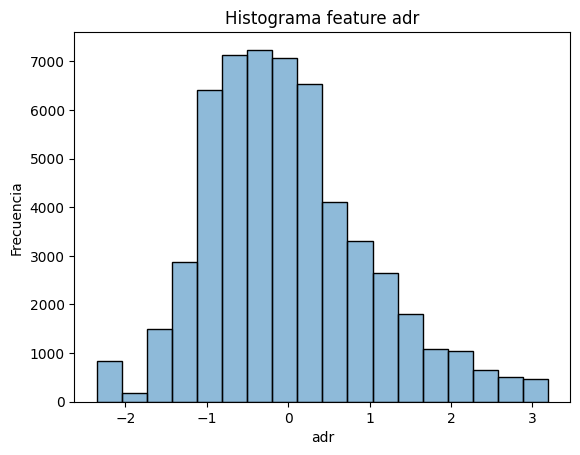

In [16]:
sns_hist=sns.histplot(data=df_work_train['adr'], alpha = 0.5, bins=18).set(title="Histograma feature adr",xlabel="adr",ylabel="Frecuencia")
plt.show()

### Variables Discretas

In [17]:
def standarizar_variable(data, columna):
  adr_z_score = standard_scaler.fit_transform(data[columna].to_frame())

  std=data[columna].std()
  mean=data[columna].mean()
  if(std != 0):
    data[columna]=(data[columna]-mean)/std

for col in columnas_discretas:
  standarizar_variable(df_work_train, col)

In [18]:
df_work_train[columnas_discretas].head(5)

,lead_time,arrival_date_year,arrival_date_week_number,arrival_date_day_of_month,stays_in_weekend_nights,stays_in_week_nights,adults,children,babies,booking_changes,days_in_waiting_list,total_of_special_requests,previous_cancellations,previous_bookings_not_canceled,required_car_parking_spaces
0,-0.565594,-0.204777,0.725506,-1.221203,0.044091,-0.281035,-1.490214,-0.254427,-0.07673,-0.351917,0,0.595148,-0.103707,0,-0.219873
1,-1.025825,-1.597432,1.243908,1.737287,-0.957152,-0.803960,0.204347,-0.254427,-0.07673,-0.351917,0,-0.693824,-0.103707,0,4.511239
2,-0.811050,-0.204777,1.095793,-0.310899,-0.957152,-0.803960,0.204347,4.896044,-0.07673,-0.351917,0,1.884121,-0.103707,0,-0.219873
3,-0.800823,-0.204777,1.762311,-0.424687,1.045334,1.287741,0.204347,-0.254427,-0.07673,-0.351917,0,-0.693824,-0.103707,0,-0.219873
4,-0.003090,1.187878,-1.125932,0.371830,1.045334,1.287741,0.204347,-0.254427,-0.07673,-0.351917,0,0.595148,-0.103707,0,-0.219873


## One Hot encoding

Para aquellas **variables cualitativas de texto** que presentan los mismos valores tanto en el train como en el test, utitilizamos *One Hot Encoding* para que puedan ser procesadas por los modelos

In [19]:
columnas_dummies = [   
    "hotel",
    "deposit_type",
    "distribution_channel",
    "market_segment",
    "customer_type",
    "country_prt",
    'meal'
]

df_work_train = pd.get_dummies(df_work_train, columns=columnas_dummies, drop_first=True)
df_work_test_submission = pd.get_dummies(df_work_test_submission, columns=columnas_dummies, drop_first=True)

Se eliminan aquellas variables dummies que contienen informacion redundante

In [20]:
df_work_train.columns.size

41

## Separación en x e y

Separacion entre columnas de decision y de target

In [21]:
#Creo un dataset con los features que voy a usar para clasificar
x_work = df_work_train.drop(['is_canceled'], axis='columns', inplace=False)

#Creo un dataset con la variable target
y_work = df_work_train['is_canceled'].copy()

x_train, x_test, y_train, y_test = train_test_split(x_work,
                                                    y_work, 
                                                    test_size=0.25,  #proporcion 75/25
                                                    random_state=2, #semilla
                                                    stratify=df_work_train['is_canceled'].values) 

x_test_submission = df_work_test_submission.copy()                                               

# Entrenamiento y prediccion de modelos

## KNN (k-nearest neighbors)

In [ ]:
n_combinations = 10
kfoldcv = StratifiedKFold(n_splits=5)

#Grilla de Parámetros
params = { 
    'n_neighbors':range(1,30), 
    'weights':['distance','uniform'],
    'algorithm':['ball_tree', 'kd_tree', 'brute'],
    'metric':['euclidean','manhattan','chebyshev']
}

#Clasificador KNN
knn_class=KNeighborsClassifier()

#Random Search con 10 Folds y 10 iteraciones
knn_rand = RandomizedSearchCV(knn_class, params, cv=kfoldcv, scoring='f1', n_iter=n_combinations, random_state=5)

knn_rand.fit(x_train, y_train)

#Mejores hiperparametros
print("Mejores hiperparametros: ", knn_rand.best_params_)
#Mejor métrica
print("Mejor métrica: ",knn_rand.best_score_)

RandomizedSearchCV(cv=StratifiedKFold(n_splits=5, random_state=None, shuffle=False),
                   estimator=KNeighborsClassifier(),
                   param_distributions={'algorithm': ['ball_tree', 'kd_tree',
                                                      'brute'],
                                        'metric': ['euclidean', 'manhattan',
                                                   'chebyshev'],
                                        'n_neighbors': range(1, 30),
                                        'weights': ['distance', 'uniform']},
                   random_state=5, scoring='f1')

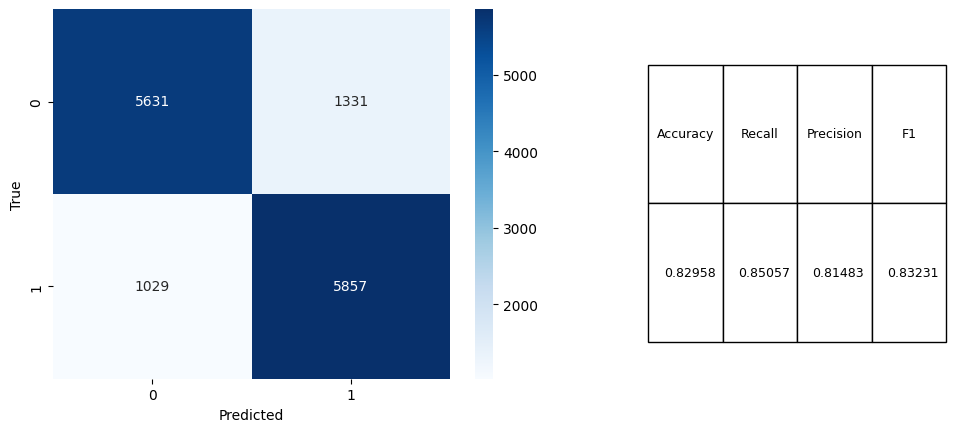

In [ ]:
#Mejor estimador
best_knn=knn_rand.best_estimator_

#Predicción con mejor estimador
best_knn_y_pred=best_knn.predict(x_test)

metricas_modelo(y_test, best_knn_y_pred)

##SVM

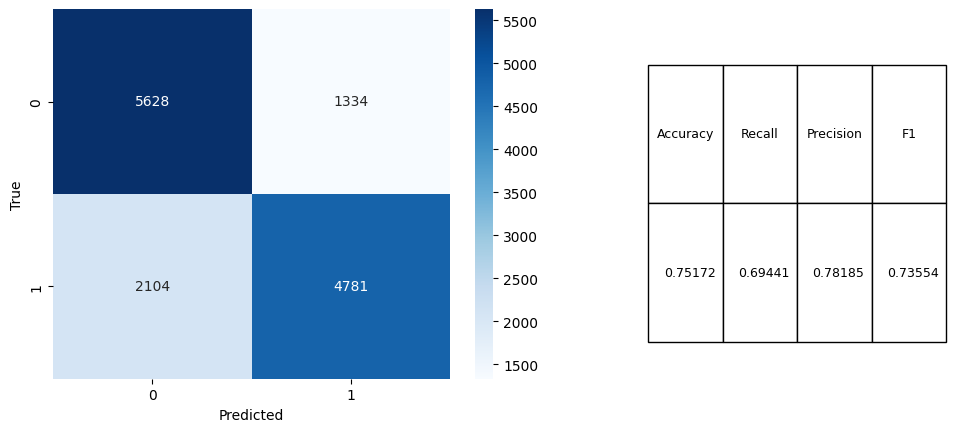

In [22]:
svm = SVC()

#Lo entreno con los datos sin escalar
svm.fit(x_train, y_train)

#Hago la prediccion y calculo las métricas
y_pred=svm.predict(x_test)
metricas_modelo(y_test, y_pred)

###PCA

Text(0, 0.5, 'Varianza Explicada (%)')

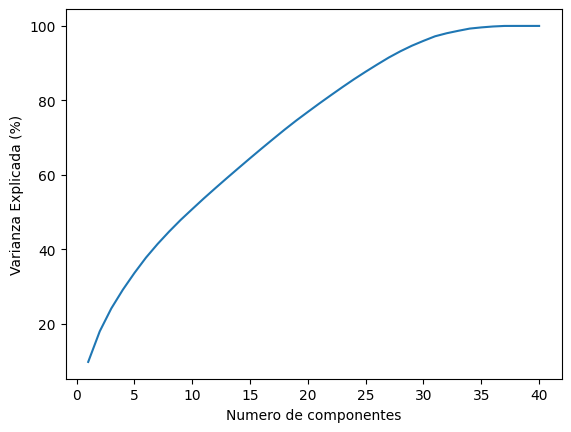

In [23]:
from sklearn.preprocessing import StandardScaler
from sklearn.decomposition import PCA

#Escalo los datos de entrenamiento
sc = StandardScaler()
x_train_scaled = sc.fit_transform(x_train)

# PCA sobre los datos escalados
pca = PCA(n_components = None)
pca.fit(x_train_scaled)

#Cantidad de Componentes
componentes = len(pca.explained_variance_ratio_) 

#Grafico la Varianza Explicada 
plt.plot(range(1,componentes+1), np.cumsum(pca.explained_variance_ratio_ * 100))
plt.xlabel("Numero de componentes")
plt.ylabel("Varianza Explicada (%)")

              precision    recall  f1-score   support

           0       0.77      0.81      0.79      6962
           1       0.79      0.76      0.78      6885

    accuracy                           0.78     13847
   macro avg       0.78      0.78      0.78     13847
weighted avg       0.78      0.78      0.78     13847



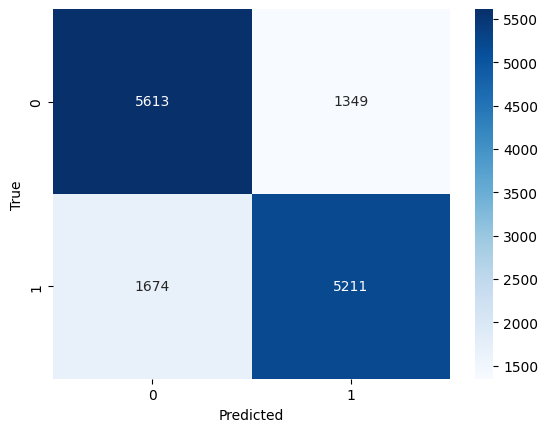

In [24]:
from sklearn.pipeline import Pipeline

#Defino el tipo de escalado, la transformacion PCA y el modelo
_sc = StandardScaler()
_pca = PCA(n_components = 6)
_model = SVC()

#Creo un pipeline
svm_model = Pipeline([
    ('std_scaler', _sc),
    ('pca', _pca),
    ('svm', _model)
])

#Entreno sobre los datos que serán previamente escalados y transformados
svm_model.fit(x_train,y_train)

#Hago la predicción y calculo las métricas
y_pred_pca=svm_model.predict(x_test)
metricas(y_pred_pca,y_test)

In [25]:
import plotly.express as px

pca = PCA()
componentes = pca.fit_transform(x_train_scaled)

labels = {
    str(i): f"PC {i+1} ({var:.1f}%)"
    for i, var in enumerate(pca.explained_variance_ratio_ * 100)
}

fig = px.scatter_matrix(
    componentes,
    labels=labels,
    dimensions=range(3),
    color=y_train
)

fig.update_traces(diagonal_visible=False)
fig.show()

###Kernels

              precision    recall  f1-score   support

           0       0.80      0.80      0.80      6962
           1       0.80      0.80      0.80      6885

    accuracy                           0.80     13847
   macro avg       0.80      0.80      0.80     13847
weighted avg       0.80      0.80      0.80     13847



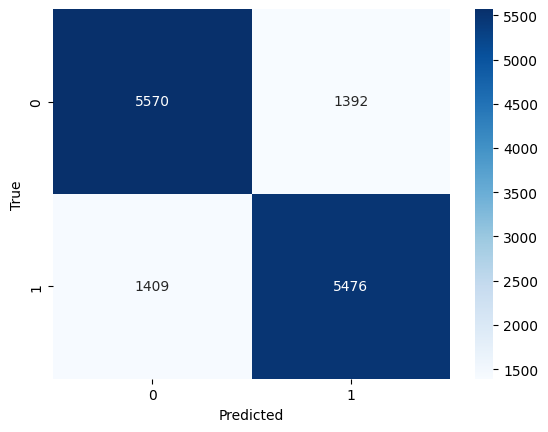

In [20]:
#Creo un clasificador con kernel lineal y lo entreno sobre los datos escalados min-max
clf = SVC(kernel='linear', C=5)
clf.fit(x_train, y_train)

#Hago la predicción y calculo las métricas
y_pred_lin=clf.predict(x_test)
metricas(y_pred_lin,y_test)

              precision    recall  f1-score   support

           0       0.67      0.98      0.79      6962
           1       0.96      0.51      0.66      6885

    accuracy                           0.74     13847
   macro avg       0.81      0.74      0.73     13847
weighted avg       0.81      0.74      0.73     13847



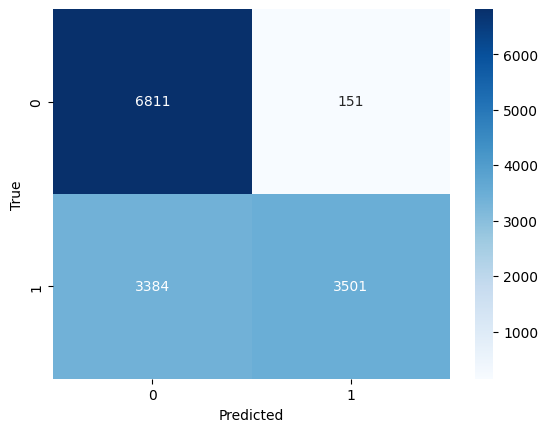

In [26]:
#Creo un clasificador con kernel radial y lo entreno sobre los datos escalados min-max
clf = SVC(kernel='rbf', C=5, gamma=10)
clf.fit(x_train, y_train)

#Hago la predicción y calculo las métricas
y_pred_rad=clf.predict(x_test)
metricas(y_pred_rad,y_test)

##Random Forest

In [ ]:
rfc_default = RandomForestClassifier()
rfc_default.get_params()

{'bootstrap': True,
 'ccp_alpha': 0.0,
 'class_weight': None,
 'criterion': 'gini',
 'max_depth': None,
 'max_features': 'sqrt',
 'max_leaf_nodes': None,
 'max_samples': None,
 'min_impurity_decrease': 0.0,
 'min_samples_leaf': 1,
 'min_samples_split': 2,
 'min_weight_fraction_leaf': 0.0,
 'n_estimators': 100,
 'n_jobs': None,
 'oob_score': False,
 'random_state': None,
 'verbose': 0,
 'warm_start': False}

In [ ]:
#Creamos un clasificador con hiperparámetros arbitrarios
rfc = RandomForestClassifier(max_features='auto', 
                             oob_score=True, 
                             random_state=2, 
                             n_jobs=-1,
                             criterion="entropy", 
                             min_samples_leaf=5,
                             min_samples_split=5,
                             n_estimators=50 )
#Entrenamos el modelo
model = rfc.fit(X = x_train, y = y_train)

/usr/local/lib/python3.10/dist-packages/sklearn/ensemble/_forest.py:424: FutureWarning: `max_features='auto'` has been deprecated in 1.1 and will be removed in 1.3. To keep the past behaviour, explicitly set `max_features='sqrt'` or remove this parameter as it is also the default value for RandomForestClassifiers and ExtraTreesClassifiers.
  warn(


In [ ]:
y_pred = model.predict(x_test)


Text(50.722222222222214, 0.5, 'True')

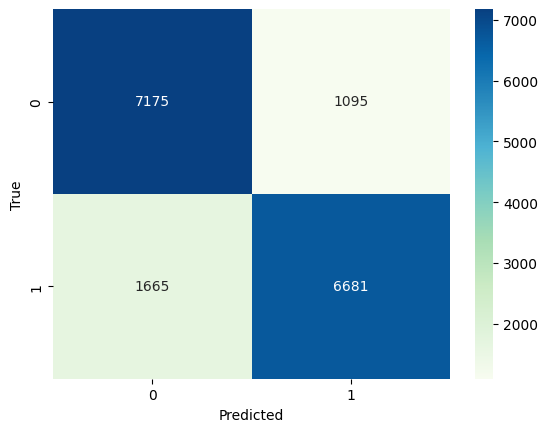

In [ ]:
tabla=confusion_matrix(y_test, y_pred)

#Grafico la matriz de confusión
sns.heatmap(tabla,cmap='GnBu',annot=True,fmt='g')
plt.xlabel('Predicted')
plt.ylabel('True')

In [ ]:
#Calculo las métricas en el conjunto de evaluación
accuracy=accuracy_score(y_test,y_pred)
recall=recall_score(y_test,y_pred)
f1=f1_score(y_test,y_pred)

print("Accuracy: "+str(accuracy))
print("Recall: "+str(recall))
print("f1 score: "+str(f1))

Accuracy: 0.8338950409244102
Recall: 0.8005032350826743
f1 score: 0.8288053591365836


###Gráfico

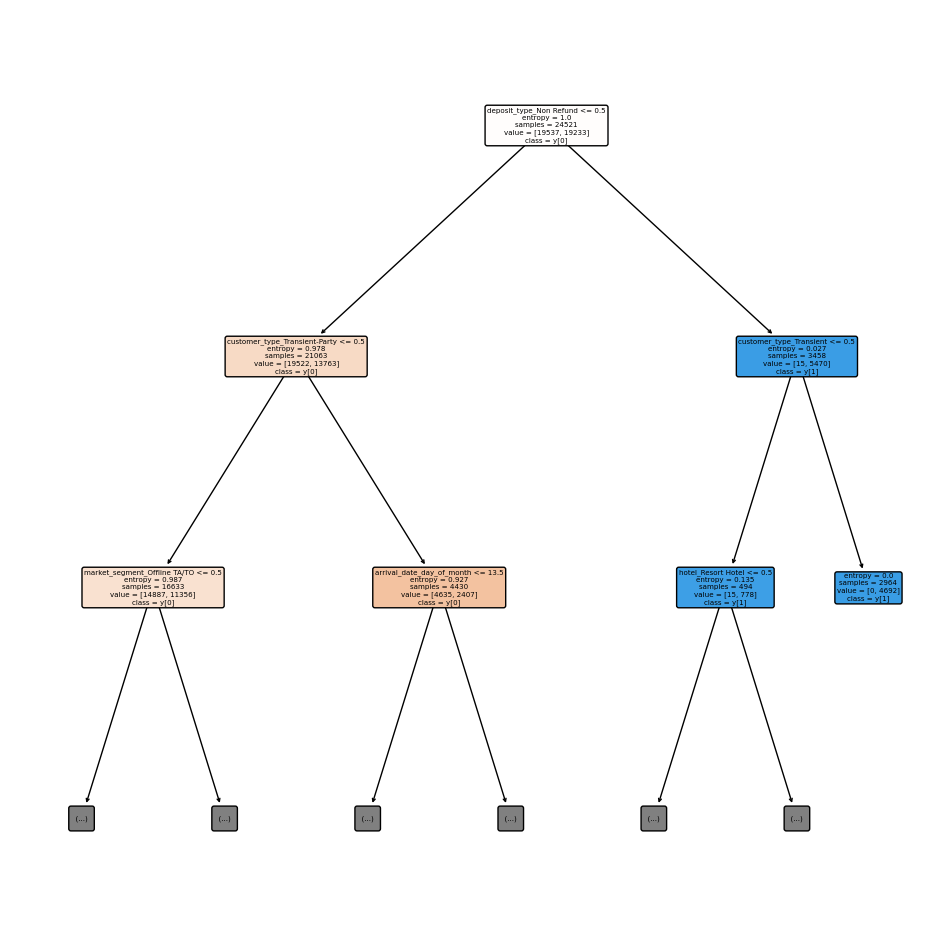

In [ ]:
plt.figure(figsize=(12,12))

tree_plot=tree.plot_tree(model.estimators_[48],
                         max_depth=2,
                         feature_names=x_work.columns.to_list(),
                         filled=True,
                         rounded=True,
                         class_names=True)

plt.show(tree_plot)

In [ ]:
rf_cv = RandomForestClassifier(max_features='auto', oob_score=True, random_state=1, n_jobs=-1)

param_grid = { "criterion" : ["gini", "entropy"], 
               "min_samples_leaf" : [1, 5, 10], 
               "min_samples_split" : [2, 4, 10, 12, 16], 
               "n_estimators": [10,20, 50] }

#Probamos entrenando sólo con 1 métrica
gs = GridSearchCV(estimator=rf_cv, param_grid=param_grid, scoring="accuracy", cv=5, n_jobs=-1)
gs_fit = gs.fit(X = x_train, y = y_train)

/usr/local/lib/python3.10/dist-packages/sklearn/ensemble/_forest.py:424: FutureWarning: `max_features='auto'` has been deprecated in 1.1 and will be removed in 1.3. To keep the past behaviour, explicitly set `max_features='sqrt'` or remove this parameter as it is also the default value for RandomForestClassifiers and ExtraTreesClassifiers.
  warn(


In [ ]:
gs_fit.best_params_

{'criterion': 'gini',
 'min_samples_leaf': 1,
 'min_samples_split': 4,
 'n_estimators': 50}

In [ ]:
#Obtenemos el mejor modelo
rf_cv_best=gs_fit.best_estimator_

#Predicción
y_pred_rf_cv_best = rf_cv_best.predict(x_test)

              precision    recall  f1-score   support

           0       0.83      0.87      0.85      8270
           1       0.86      0.82      0.84      8346

    accuracy                           0.84     16616
   macro avg       0.84      0.84      0.84     16616
weighted avg       0.84      0.84      0.84     16616



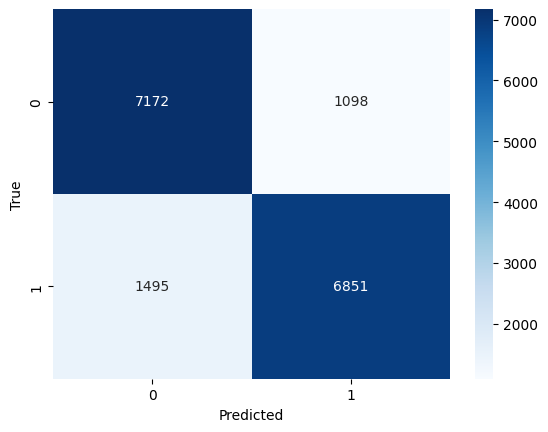

In [ ]:
#Creo matriz de confusión
tabla=confusion_matrix(y_test,y_pred_rf_cv_best)

#Grafico matriz de confusión
sns.heatmap(tabla, cmap='Blues',annot=True,fmt='g')
plt.xlabel('Predicted')
plt.ylabel('True')

#Reporte
print(classification_report(y_test,y_pred_rf_cv_best))

In [ ]:
#Evaluo la performance en el conjunto de evaluación
accuracy=accuracy_score(y_test,y_pred_rf_cv_best)
recall=recall_score(y_test,y_pred_rf_cv_best)
f1=f1_score(y_test,y_pred_rf_cv_best)

print("Accuracy: "+str(accuracy))
print("Recall: "+str(recall))
print("f1 score: "+str(f1))

Accuracy: 0.8439455946076071
Recall: 0.8208722741433022
f1 score: 0.8408714329548942


In [ ]:
rf_cv = RandomForestClassifier(max_features='auto', oob_score=True, random_state=1, n_jobs=-1)

param_grid = { "criterion" : ["gini", "entropy"], 
               "min_samples_leaf" : [1, 5, 10], 
               "min_samples_split" : [2, 4, 10, 12, 16], 
               "n_estimators": [10,20, 50] }

#Probamos entrenando con varias métricas

metricas=['accuracy','f1','roc_auc'] #'recall','precision'

gs_multimetrica = GridSearchCV(estimator=rf_cv, 
                               param_grid=param_grid, 
                               scoring=metricas, 
                               refit=False, 
                               cv=5, 
                               n_jobs=-1)
#Entrenamiento
gs_multimetrica_fit = gs_multimetrica.fit(X = x_train, y = y_train)

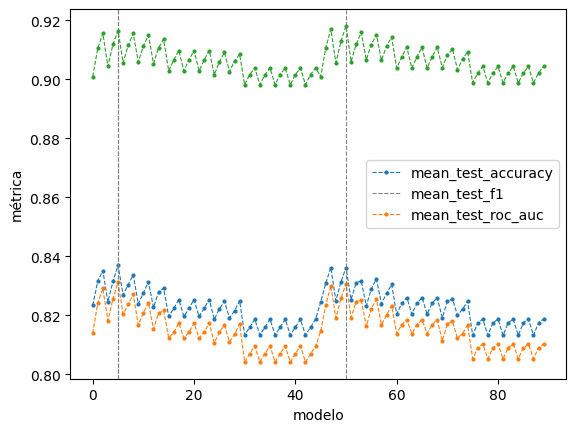

In [ ]:
labels=[ key for key in gs_multimetrica_fit.cv_results_.keys() if("mean_test" in key)]

for k in labels:
    plt.plot(gs_multimetrica_fit.cv_results_[k],linestyle='--' , linewidth=0.8,marker='o',markersize=2)     
    x_linea=np.argmax(gs_multimetrica_fit.cv_results_[k])
    plt.axvline(x_linea,linestyle='--' ,linewidth=0.8,color='grey')
        
plt.xlabel("modelo", fontsize=10)
plt.ylabel("métrica", fontsize=10)
plt.legend(labels)
plt.show()

In [ ]:
params_elegidos=gs_multimetrica_fit.cv_results_['params'][np.argmax(gs_multimetrica_fit.cv_results_['mean_test_accuracy'])]
params_elegidos

{'criterion': 'gini',
 'min_samples_leaf': 1,
 'min_samples_split': 4,
 'n_estimators': 50}

In [ ]:
#Creamos un clasificador RF
rfc_multimetrica = RandomForestClassifier(criterion= params_elegidos['criterion'], 
                                          min_samples_leaf= params_elegidos['min_samples_leaf'], 
                                          min_samples_split= params_elegidos['min_samples_split'], 
                                          n_estimators=params_elegidos['n_estimators'], 
                                          oob_score=True, random_state=2, n_jobs=-1)
#Entrenamos un modelo
model_rfc_multimetrica = rfc_multimetrica.fit(X = x_train, y = y_train)

#Hacemos una predicción
y_pred_model_rfc_multimetrica = model_rfc_multimetrica.predict(x_test)

              precision    recall  f1-score   support

           0       0.83      0.87      0.85      8270
           1       0.86      0.82      0.84      8346

    accuracy                           0.85     16616
   macro avg       0.85      0.85      0.85     16616
weighted avg       0.85      0.85      0.85     16616



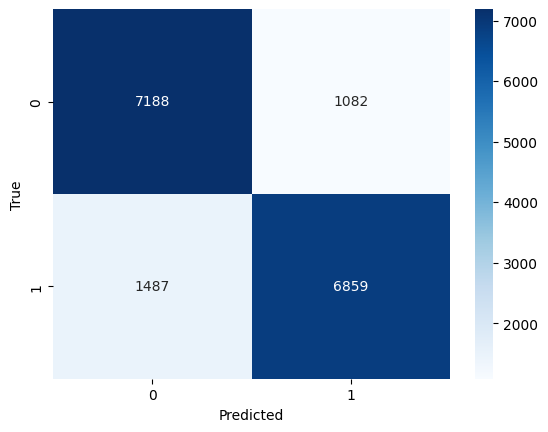

In [ ]:
#Matriz de Confusión
cm = confusion_matrix(y_test,y_pred_model_rfc_multimetrica)
sns.heatmap(cm, cmap='Blues',annot=True,fmt='g')
plt.xlabel('Predicted')
plt.ylabel('True')

#Reporte
print(classification_report(y_test,y_pred_model_rfc_multimetrica))


##XGBoost

In [22]:
xgb_model = xgb.XGBClassifier(random_state=0, n_estimators=50)
xgb_model.fit(x_train, y_train)

XGBClassifier(base_score=None, booster=None, callbacks=None,
              colsample_bylevel=None, colsample_bynode=None,
              colsample_bytree=None, early_stopping_rounds=None,
              enable_categorical=False, eval_metric=None, feature_types=None,
              gamma=None, gpu_id=None, grow_policy=None, importance_type=None,
              interaction_constraints=None, learning_rate=None, max_bin=None,
              max_cat_threshold=None, max_cat_to_onehot=None,
              max_delta_step=None, max_depth=None, max_leaves=None,
              min_child_weight=None, missing=nan, monotone_constraints=None,
              n_estimators=50, n_jobs=None, num_parallel_tree=None,
              predictor=None, random_state=0, ...)

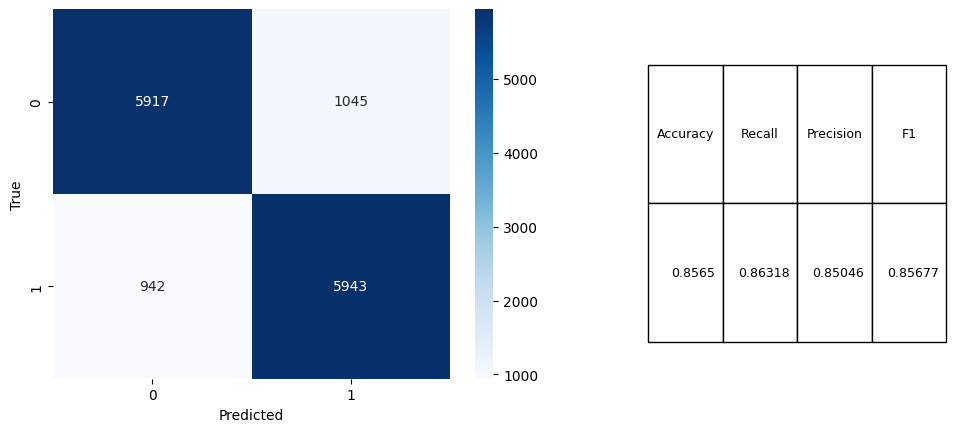

In [23]:
#Predicción con mejor estimador
y_pred=xgb_model.predict(x_test)

metricas_modelo(y_test, y_pred)

### Hiperparametros optimizados por Cross Validation

In [24]:
xgb_class = xgb.XGBClassifier()

#Metrica que quiero optimizar F1 Score
scorer_fn = make_scorer(sk.metrics.f1_score)

#Cantidad de splits para el Cross Validation
folds=10

#Kfold estratificado
kfoldcv = StratifiedKFold(n_splits=folds)

#Grilla de Parámetros
params = { 
    'learning_rate': [0.05, 0.10, 0.15, 0.2, 0.3, 0.4], # tasa de aprendizaje
    'max_depth': range(5, 15), #máxima profundidad de cada árbol
    'n_estimators': range(30, 60), #cantidad de árboles a construir
    #'min_child_weight' : [ 1, 3, 5, 7 ],
    #'colsample_bytree' : [ 0.3, 0.4, 0.5 , 0.7 ]
}

#Random Search con 10 Folds y 20 iteraciones
n = 20
xgb_rand = RandomizedSearchCV(estimator=xgb_class, param_distributions = params, scoring=scorer_fn, cv=kfoldcv, n_iter=n) 

xgb_rand.fit(x_train, y_train)

#Mejores hiperparametros
print("Mejores hiperparametros: ", xgb_rand.best_params_)
#Mejor métrica
print("Mejor métrica: ",xgb_rand.best_score_)

Mejores hiperparametros:  {'n_estimators': 45, 'max_depth': 13, 'learning_rate': 0.2}
Mejor métrica:  0.8696298829548583


In [47]:
#Mejor estimador
best_xgb_model=rand.best_estimator_

#Predicción con mejor estimador
best_xgb_y_pred=best_xgb_model.predict(x_test)

metricas_modelo(y_test, best_xgb_y_pred)

NameError: ignored

#Voting

In [27]:
from sklearn.ensemble import RandomForestClassifier 
from sklearn.linear_model import LogisticRegression 
from sklearn.neighbors import KNeighborsClassifier
from sklearn.ensemble import VotingClassifier
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score
from sklearn.datasets import make_classification

In [28]:
#Creo un conjunto de datos para entrenar los modelos

x, y = make_classification(n_samples=3000, 
                           n_features=20, 
                           n_informative=15, 
                           n_redundant=5,
                           n_clusters_per_class=5,
                           class_sep=0.7,
                           flip_y=0.03,
                           n_classes=2)

In [29]:
#Creo clasificadores

log_clf = LogisticRegression()
rnd_clf = RandomForestClassifier()
knn_clf = KNeighborsClassifier()

#Creo ensemble de Votación
vot_clf = VotingClassifier(estimators = [('lr', log_clf), ('rnd', rnd_clf), ('knn', knn_clf)], voting = 'hard')

#Armo conjunto entrenamiento y test 80-20
x_train, x_test, y_train, y_test = train_test_split(x, y, random_state = 42, train_size = 0.80)


#Entreno el ensemble
vot_clf.fit(x_train, y_train)

#Evaluo en conjunto de test
pred = vot_clf.predict(x_test)
accuracy_score(y_test, pred)

0.7516666666666667

#Stacking

In [38]:
#Creo un conjunto de datos para entrenar los modelos
x, y = make_classification(n_samples=3000, 
                           n_features=20, 
                           n_informative=15, 
                           n_redundant=5,
                           n_clusters_per_class=5,
                           class_sep=0.7,
                           flip_y=0.03,
                           n_classes=2)

In [42]:
#Modelos Base
base_models = {'random_forest':RandomForestClassifier(n_estimators=50),
               'svm': SVC(),
               'knn': KNeighborsClassifier(n_neighbors=11)}

#Guarda los scores de cada modelo
model_scores = defaultdict()

#Entreno los clasificadores
for name, model in base_models.items():
    print('Evaluating {}'.format(name))
    scores = evaluate_model(model, x_train, y_train)
    model_scores[name] = scores

Evaluating random_forest


[Parallel(n_jobs=3)]: Using backend LokyBackend with 3 concurrent workers.
[Parallel(n_jobs=3)]: Done  10 out of  10 | elapsed:   12.1s finished
[Parallel(n_jobs=3)]: Using backend LokyBackend with 3 concurrent workers.


Evaluating svm


[Parallel(n_jobs=3)]: Done  10 out of  10 | elapsed:    1.9s finished
[Parallel(n_jobs=3)]: Using backend LokyBackend with 3 concurrent workers.


Evaluating knn


[Parallel(n_jobs=3)]: Done  10 out of  10 | elapsed:    0.2s finished


In [43]:
from sklearn.ensemble import StackingClassifier

#Modelos Base
base_models = [('random_forest', RandomForestClassifier(n_estimators=50)),
               ('svm', SVC()),
               ('knn', KNeighborsClassifier(n_neighbors=11))]

#Meta Modelo
meta_model = LogisticRegressionCV()

#Ensemble Stacking
stacking_model = StackingClassifier(estimators=base_models, 
                                    final_estimator=meta_model, 
                                    passthrough=True, 
                                    cv=5,
                                    verbose=2)

In [44]:
#Performance el modelo en entrenamiento
stacking_scores = evaluate_model(stacking_model, x_train, y_train)
model_scores['stacking'] = stacking_scores

[Parallel(n_jobs=3)]: Using backend LokyBackend with 3 concurrent workers.
[Parallel(n_jobs=3)]: Done  10 out of  10 | elapsed:   34.1s finished


In [45]:
#Grafico performance
plot_results(model_scores, name='stacking_model_cv')

In [46]:
#Evaluo en conjunto de test
#stacking_model.fit(x_train,y_train).score(x_test,y_test)
stacking_model.fit(x_train,y_train)
y_pred_st = stacking_model.predict(x_test)
accuracy_score(y_test, y_pred_st)

[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    1.3s remaining:    0.0s
[Parallel(n_jobs=1)]: Done   5 out of   5 | elapsed:    4.0s finished
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    0.2s remaining:    0.0s
[Parallel(n_jobs=1)]: Done   5 out of   5 | elapsed:    0.9s finished
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=1)]: Done   5 out of   5 | elapsed:    0.1s finished


0.7866666666666666

# Submission

Se realiza una prediccion a partir de las columnas de decision del dataframe de test

In [ ]:
y_pred = best_xgb_model.predict(x_test_submission)
df_submission = pd.DataFrame({"id": df_test_submission["id"], "is_canceled": y_pred})
df_submission

,id,is_canceled
0,e6d0d58a-ab96-44d3-b28f-85df1cc15f1e,1
1,aba9aac2-4495-4645-a60e-90328713c999,0
2,b345b5dc-c804-4d77-a39f-1f4e65d1f1ad,0
3,ce1b400e-afa1-4946-bdff-004b859eb61c,1
4,c4fbec0d-8e2e-4db2-9d4f-a6ccb9f51214,1
...,...,...
26530,636ccded-66ad-4538-8006-c0b9f84c6256,0
26531,11e19741-bd28-4459-8ea3-184f1664000f,0
26532,36a4c7b0-d6b1-4528-93db-311be96ec1c6,1
26533,89c85fa5-2b3d-4131-844c-e151a65ca240,1


In [ ]:
from google.colab import files

file_name = 'submission ' + datetime.now().strftime("%d-%m %H:%M:%S") + '.csv'
df_submission.to_csv(file_name, encoding = 'utf-8-sig', index=False) 
files.download(file_name)

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>